In [1]:
%load_ext autoreload
%autoreload 2

import sys

sys.path.append('/home/xilinx/jupyter_notebooks/qickdawg/src/')

import qickdawg as qd
from copy import copy
import matplotlib.pyplot as plt

In [2]:
qd.start_client(bitfile="/home/xilinx/jupyter_notebooks/qickdawg/firmware/photon_counting/qick_4x2.bit")

In [3]:
min_step_us = qd.soccfg.cycles2us(1) # this is the minimum step size in us, which is the time for one clock cycle
min_step_ns = min_step_us*1e3
max_int_time_us = min_step_us * (2**16 - 1)
max_int_time_ns = min_step_ns * (2**16 - 1)

In [5]:
default_config = qd.NVConfiguration()

default_config.adc_channel = 0 

default_config.mw_channel = 0
default_config.mw_nqz = 1
default_config.mw_gain = 5000
default_config.reps = 1

default_config.ddr4 = True
default_config.ddr4_channel = 0
default_config.n_ddr4_chunks = 10

default_config.laser_gate_pmod = 0

default_config.relax_delay_treg = 150 # between each rep, wait for everything to catch up, mostly aom


In [13]:
qd.soc.clear_ddr4()

config = copy(default_config)

config.soft_avgs = 1
config.readout_integration_treg = 1020
prog = qd.LaserOn(config)
data = prog.acquire_decimated()


  0%|          | 0/1 [00:00<?, ?it/s]

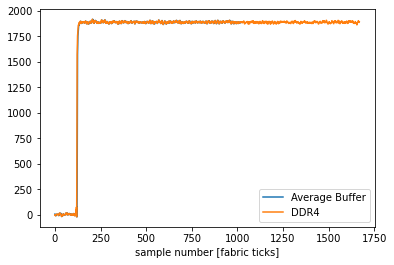

In [14]:
iq_ddr4 = qd.soc.get_ddr4(10)

plt.plot(data, label='Average Buffer')

plt.plot(iq_ddr4[90:,0],label="DDR4")
plt.xlabel("sample number [fabric ticks]")
plt.legend();
plt.show()


In [15]:
print(prog.asm())


// Program

          synci 100;
          regwi 0, $16, 8192;                   //out = 0b0010000000000000
          seti 7, 0, $16, 0;                    //ch =0 out = $16 @t = 0
          seti 7, 0, $0, 10;                    //ch =0 out = 0 @t = 0
          synci 100;
          regwi 0, $13, 0;
          regwi 0, $14, 0;
LOOP_rep: regwi 0, $16, 16385;                  //out = 0b0100000000000001
          seti 7, 0, $16, 0;                    //ch =0 out = $16 @t = 0
          waiti 0, 1020;
          synci 150;
          mathi 0, $13, $13 + 1;
          memwi 0, $13, 1;
          loopnz 0, $14, @LOOP_rep;
          end ;


In [16]:
qd.soc.clear_ddr4()

config = copy(default_config)

config.soft_avgs = 1
config.readout_integration_treg = 1020
config.adc_trigger_offset_treg = 0
prog = qd.LaserOff(config)

data = prog.acquire_decimated(readouts_per_experiment=1)

  0%|          | 0/1 [00:00<?, ?it/s]

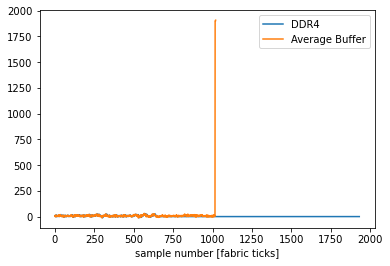

In [17]:
iq_ddr4 = qd.soc.get_ddr4(15)

plt.plot(iq_ddr4[78+1030:,0],label="DDR4")
plt.plot(data, label="Average Buffer")

plt.xlabel("sample number [fabric ticks]")
plt.legend();
plt.show()


In [18]:
print(prog.asm())


// Program

          synci 100;
          regwi 0, $16, 8192;                   //out = 0b0010000000000000
          seti 7, 0, $16, 0;                    //ch =0 out = $16 @t = 0
          seti 7, 0, $0, 10;                    //ch =0 out = 0 @t = 0
          synci 100;
          regwi 0, $16, 1;                      //out = 0b0000000000000001
          seti 7, 0, $16, 0;                    //ch =0 out = $16 @t = 0
          seti 7, 0, $0, 10;                    //ch =0 out = 0 @t = 0
          synci 1020;
          regwi 0, $13, 0;
          regwi 0, $14, 0;
LOOP_rep: regwi 0, $16, 16384;                  //out = 0b0100000000000000
          seti 7, 0, $16, 0;                    //ch =0 out = $16 @t = 0
          seti 7, 0, $0, 10;                    //ch =0 out = 0 @t = 0
          waiti 0, 1020;
          synci 150;
          mathi 0, $13, $13 + 1;
          memwi 0, $13, 1;
          loopnz 0, $14, @LOOP_rep;
          end ;
